In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import healpy as hp
import tensorflow as tf
import matplotlib.pyplot as plt

from deepsphere import healpy_layers

from msfm.fiducial_pipeline import FiducialPipeline
from msfm.utils import scales

24-02-14 05:48:13   imports.py INF   Setting up healpy to run on 256 CPUs 
24-02-14 05:48:13   imports.py INF   Setting up healpy to run on 256 CPUs 


In [3]:
n_side = 512
n_pix = hp.nside2npix(n_side)
l_min = 0
theta_fwhm = 30.0
l_max_naive = scales.angle_to_ell(theta_fwhm, arcmin=True, method="naive")

In [4]:
conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v6/linear_bias.yaml"
tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v6/linear_bias/tfrecords/fiducial/DESy3_fiducial_*.tfrecord"

pipe = FiducialPipeline(
    conf,
    params=[],
    with_lensing=True,
    with_clustering=True,
    apply_norm=False,
)

dset = pipe.get_dset(
    tfr_pattern,
    local_batch_size=1,
    n_noise=3,
)

for x, index in dset.take(1):
    print(x.shape)

24-02-14 05:48:14     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
24-02-14 05:48:14     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
24-02-14 05:48:16 fiducial_pip INF   Shuffling file names with shuffle_buffer = 16 
24-02-14 05:48:16 fiducial_pip INF   Interleaving with n_readers = 8 
24-02-14 05:48:17 fiducial_pip INF   Shuffling examples with shuffle_buffer = 64 
24-02-14 05:48:17 fiducial_pip INF   Batching into 1 elements locally 
24-02-14 05:48:18 fiducial_pip WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.exp

### unsmoothed map

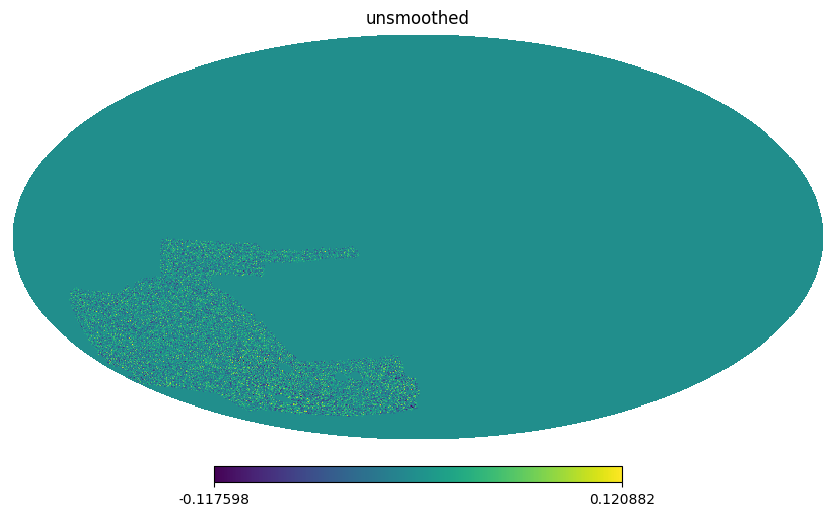

In [5]:
i_z = 0
data_vec_pix = pipe.data_vec_pix
raw_map = np.zeros(n_pix)
raw_map[data_vec_pix] = x[0,:,i_z]
raw_map = hp.reorder(raw_map, n2r=True)

hp.mollview(raw_map, title="unsmoothed")

In [6]:
raw_cls = hp.anafast(raw_map)

raw_map_smoothed_cls = scales.cls_to_smoothed_cls(
    raw_cls, 
    l_min=l_min, 
    theta_fwhm=theta_fwhm
)

### smoothed map

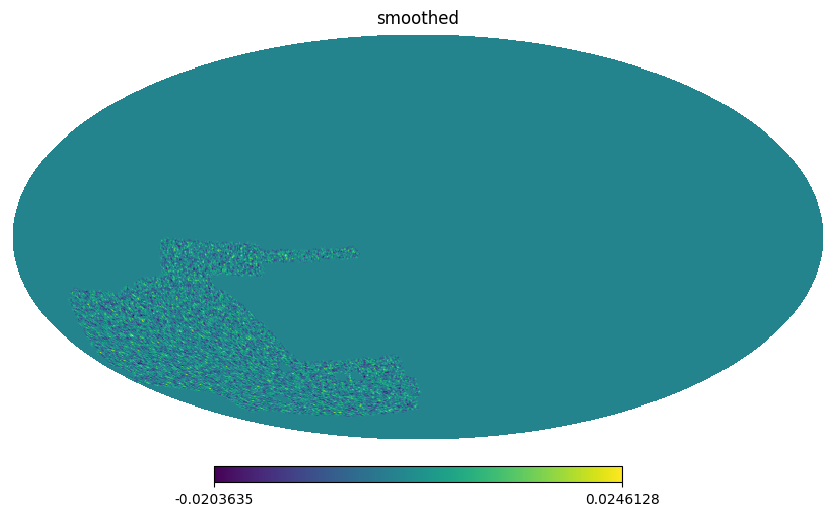

In [7]:
smoothed_map, direct_smoothed_alms = scales.map_to_smoothed_map(
    raw_map, 
    n_side, 
    l_min=l_min,
    theta_fwhm=theta_fwhm,
    nest=False,
)

hp.mollview(smoothed_map, title="smoothed")

direct_smoothed_cls = hp.alm2cl(direct_smoothed_alms)

In [8]:
smoothed_map_raw_cls = hp.anafast(smoothed_map)

### comparison

Text(0.5, 0.98, 'nside = 512 with fwhm = 30.0 arcmin smoothing')

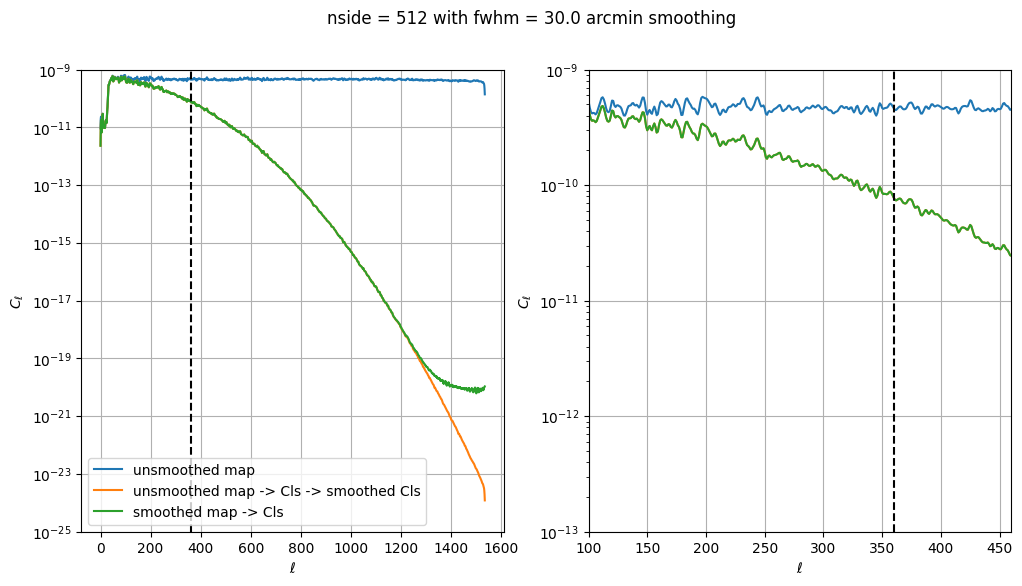

In [11]:
fig, ax = plt.subplots(figsize=(12,6), ncols=2)

ax[0].plot(raw_cls, label="unsmoothed map")
ax[0].plot(raw_map_smoothed_cls, label="unsmoothed map -> Cls -> smoothed Cls")
ax[0].plot(smoothed_map_raw_cls, label="smoothed map -> Cls")
ax[0].axvline(l_max_naive, color="k", linestyle="--")
ax[0].set(xlabel=r"$\ell$", ylabel=r"$C_\ell$", yscale="log", ylim=(1e-25,1e-9))
ax[0].legend()
ax[0].grid(True)

ax[1].plot(raw_cls, label="unsmoothed map")
ax[1].plot(raw_map_smoothed_cls, label="unsmoothed map -> Cls -> smoothed Cls")
ax[1].plot(smoothed_map_raw_cls, label="smoothed map -> Cls")
ax[1].axvline(l_max_naive, color="k", linestyle="--")
ax[1].set(xlabel=r"$\ell$", ylabel=r"$C_\ell$", yscale="log", ylim=(1e-13, 1e-9), xlim=(100, l_max_naive+100))
ax[1].grid(True)

fig.suptitle(f"nside = {n_side} with fwhm = {theta_fwhm} arcmin smoothing")